<h1> Research Project: Timing Variables </h1>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import DateOffset
import pickle

<h2> 1. Data </h2>

- [S&P500 Historical Constituents](#sp500_components)
- [Price and Fundamental Data](#data)

<b> Data Sources: </b>
- Historical S&P500 Constituents - https://github.com/fja05680/sp500
- Price Data - CRSP/Compustat Merged Database
- Fundamental Data - CRSP/Compustat Merged Database
- Timing Variables - FRED CPI , Chicago Fed National Activity Index

<a id = 'sp500_components'> </a>
<h3> S&P500 Historical Constituents </h3>

In [3]:
# create list of historical S&P500 constituents - for data query
path = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\S&P Historical Constituents.csv"
index = pd.read_csv(path, sep = ',', parse_dates = ['date'], index_col = 'date')

index_set = set()
for row in index['tickers']:
    list_ = row.split(',')
    index_set.update(list_)
    
string = " ".join(index_set)
text_file = open(r"S&P500.txt", "w")
text_file.write(string)
text_file.close()

In [4]:
# create one-hot table
sp500_dict = {}
date_idx = pd.to_datetime(index.index)
for idx in date_idx: 
    list_ = index.loc[idx,'tickers'].split(',')
    sp500_dict[idx] = list_
    
sp500_member = pd.DataFrame(0, index = date_idx, columns = index_set)
for date in date_idx: 
    sp500_member.loc[date, sp500_dict[date]] = 1

In [5]:
sp500_member.index + pd.offsets.MonthEnd(0)

DatetimeIndex(['1996-01-31', '1996-01-31', '1996-01-31', '1996-01-31',
               '1996-01-31', '1996-01-31', '1996-01-31', '1996-01-31',
               '1996-01-31', '1996-01-31',
               ...
               '2020-12-31', '2021-01-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31'],
              dtype='datetime64[ns]', name='date', length=2638, freq=None)

In [6]:
# get monthly historical constituent
date_range = pd.date_range('1995-01-31', '2021-12-31', freq = 'M')
date_range0 = pd.date_range('1996-01-31', '2021-11-30', freq = 'M')
date_range1 = pd.date_range('1996-02-29', '2021-12-31', freq = 'M')
sp500_member_M = pd.DataFrame(0, index = date_range, columns = index_set)
sp500_member_M

,CI,MMI,KMG,LB,RAD,CPB,AIG,MAY,RYC,CTXS,...,ADP,TX,IRM,I,PYPL,WHR,VZ,XLNX,CB,PBY
1995-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-02-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id = 'data'> <a>
<h3> Price and Fundamental Data </h3>

In [7]:
path2 = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\Factor Data.xlsx"

prices_df = pd.read_excel(path2, sheet_name = 'Price Data', index_col = 0, usecols = ['Date', 'PERMNO', 'Ticker', 'Price', 'Returns'])
value_df = pd.read_excel(path2, sheet_name = 'Value Signals', index_col = 0, usecols = ['Date', 'PERMNO', 'Ticker', 'B/M', 'CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'DPR', 'P/B'])

# change dates to month end
prices_df.index = prices_df.index + pd.offsets.MonthEnd(0)
value_df.index = value_df.index + pd.offsets.MonthEnd(0)

# to get overall universe and subset of universe 
stock_set = set(prices_df['Ticker'])
stock_set.remove(np.nan)
master_set = stock_set & index_set

print(f'Data Universe: {len(stock_set)}, Combined Universe: {len(master_set)}')

Data Universe: 1392, Combined Universe: 946


In [8]:
# Return Data
stock_returns = pd.DataFrame(index = date_range, columns = stock_set)
returns_df = prices_df[['Ticker', 'Returns']].dropna()
for date in date_range: 
    stock_returns.loc[date, list(returns_df.loc[date, 'Ticker'])] = returns_df.loc[date, 'Returns'].values

# Price Data
stock_prices = pd.DataFrame(index = date_range, columns = stock_set)
dollar_df = prices_df[['Ticker', 'Price']].dropna()
for date in date_range: 
    stock_prices.loc[date, list(dollar_df.loc[date, 'Ticker'])] = dollar_df.loc[date, 'Price'].values

<h2> 2. Methodology </h2>

<h2> 3. Implementation </h2>

- [Momentum Factor Construction](#mom_factor)
- [Value Factor Construction](#val_factor)
- [Timing Variables and Factor Returns](#factor_timing)
- [Results](#results)

In [9]:
# factor construction toolkit
def winsorize(x, ub = 99, lb = 1): 
    upper = np.percentile(x[~pd.isna(x)], ub)
    lower = np.percentile(x[~pd.isna(x)], lb)
    return np.where(x>upper, upper, np.where(x < lower, lower, x))

def z_score(df): 
    return df.sub(df.mean(axis = 1), axis = 0).div(df.std(axis = 1), axis = 0)

def calc_returns(weights, returns): 
    return (weights.shift(1, freq = 'infer') * returns).sum(axis = 1) 

def leverage(weights): 
    return weights.abs().sum(axis = 1)

def calc_vol(returns_df, weights_df, window = 12): 
    N = returns_df.shape[0]
    start = window

    vol_df = pd.DataFrame(0, index = date_range, columns = ['Vol'])

    for t in range(start, N, 1): 
        V = returns_df.iloc[t-window:t].fillna(0).cov(ddof = 0) # sample covariance matrix
        weight_t = weights_df.iloc[t].fillna(0)
        vol_df.iloc[t,:] = np.sqrt(weight_t @ V @ weight_t * 12) # portfolio volatility

    return vol_df

def calc_beta(market_df, returns_df): 
    return market_df

In [10]:
def signal_calc(signal, target_vol = 0.1): # compute self-financing beta neutral signal returns
    
    # step 1 - take z-score
    signal_z = z_score(signal).fillna(0)

    # step 2 - vol scale
    signal_vol = calc_vol(stock_returns, signal_z)
    vol_ratio = target_vol/signal_vol.loc[date_range0].values
    signal_weights = signal_z.loc[date_range0].mul(vol_ratio, axis = 0)

    # step 3 - beta neutralize

    # step 4 - compute returns
    signal_ret = (signal_weights.shift(1, freq = 'infer') * stock_returns.loc[date_range1]).sum(axis = 1)
    
    return signal_weights, signal_ret

def composite_calc(signal_dict, signal_group, target_vol = 0.1): # compute self-financing beta neutral composite returns
    
    signal_weights = {}
    for signal in signal_group: 
        # step 1 - take z-score
        signal_df = signal_dict[signal]
        signal_z = z_score(signal_df).fillna(0)

        # step 2 - vol scale
        signal_vol = calc_vol(stock_returns, signal_z)
        vol_ratio = target_vol/signal_vol.loc[date_range0].values
        signal_weights[signal] = signal_z.loc[date_range0].mul(vol_ratio, axis = 0)
        
    # step 3- equal-weighted composite
    composite_weights = pd.DataFrame(0, index = date_range0, columns = signal_z.columns)
    for signal in signal_group: 
        composite_weights += signal_weights[signal].fillna(0)
    composite_weights = composite_weights/len(signal_group) # taking average
    
    # step 4 - beta neutralize

    # step 5 - compute hedged returns
    composite_ret = (composite_weights.shift(1, freq = 'infer') * stock_returns.loc[date_range1]).sum(axis = 1)
    
    return composite_weights, composite_ret

<a id = 'mom_factor'> </a>
<h3> Momentum Factor Construction </h3> 

<h4> <font color = 'darkblue'> Testing momentum signals </font> </h4> 

In [11]:
# populating signal
mom_signals = {}
mom6_df = pd.DataFrame(index = date_range , columns = stock_set)
mom8_df = pd.DataFrame(index = date_range , columns = stock_set)
mom10_df = pd.DataFrame(index = date_range , columns = stock_set)
mom12_df = pd.DataFrame(index = date_range , columns = stock_set)
# mom14_df = pd.DataFrame(index = date_range , columns = stock_set)
for date in date_range0: 
    mom6_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(6)]) - 1
    mom6_df.loc[date] = winsorize(mom6_df.loc[date].values)
    mom8_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(8)]) - 1
    mom8_df.loc[date] = winsorize(mom8_df.loc[date].values)
    mom10_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(10)]) - 1
    mom10_df.loc[date] = winsorize(mom10_df.loc[date].values)
    mom12_df.loc[date] = (stock_prices.loc[date - pd.offsets.MonthEnd(1)] / stock_prices.loc[date - pd.offsets.MonthEnd(12)]) - 1
    mom12_df.loc[date] = winsorize(mom12_df.loc[date].values)

mom_signals['6M'] = mom6_df
mom_signals['8M'] = mom8_df
mom_signals['10M'] = mom10_df
mom_signals['12M'] = mom12_df

<ipython-input-9-9c0858b0dfac>:5: RuntimeWarning: invalid value encountered in greater
  return np.where(x>upper, upper, np.where(x < lower, lower, x))
<ipython-input-9-9c0858b0dfac>:5: RuntimeWarning: invalid value encountered in less
  return np.where(x>upper, upper, np.where(x < lower, lower, x))


In [12]:
# compute returns
mom_signals_list = ['6M', '8M', '10M', '12M']
mom_weights, mom_ret = {}, {}
for signal in mom_signals_list:
    mom_weights[signal], mom_ret[signal] = signal_calc(mom_signals[signal], 0.1) # 10% target vol

mom_ret_df = pd.DataFrame(mom_ret)

In [13]:
# Summary 
svar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
svar_summary['Return'] = mom_ret_df.mean() * 12
svar_summary['Volatility'] = mom_ret_df.std() * 12
svar_summary['Sharpe Ratio'] = mom_ret_df.mean() / mom_ret_df.std()
svar_summary.T

,6M,8M,10M,12M
Return,0.024882,0.034153,0.055166,0.059310
Volatility,0.278969,0.303538,0.385187,0.428252
Sharpe Ratio,0.089191,0.112516,0.143220,0.138493


12M momentum seems to work well enough, so we are going to use it as our momentum factor for the timing exercise.

<a id = 'val_factor'> </a> 
<h3> Value Factor Construction </h3> 

<h4> <font color = 'darkblue'> Testing value signals </font> </h4> 

In [14]:
# populating signals
value_signals = {}
value_signals_list = ['B/M', 'CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'DPR', 'P/B']
for signal in value_signals_list:
    signal_df = pd.DataFrame(index = date_range0, columns = stock_set)
    var_df = value_df[['Ticker', signal]]
    for date in date_range: 
        signal_df.loc[date, list(var_df.loc[date,'Ticker'])] = winsorize(var_df.loc[date,signal].values)
    signal_df = signal_df[stock_set]
    
    value_signals[signal] = signal_df

In [15]:
# inverting price ratios
price_ratios = ['CAPE', 'EVM', 'P/O', 'P/E', 'P/S', 'P/CF', 'P/B']
for ratio in price_ratios:
    value_signals[ratio] = 1 / value_signals[ratio]

In [16]:
# compute returns
value_weights, value_ret = {}, {}
for signal in value_signals_list:
    value_weights[signal], value_ret[signal] = signal_calc(value_signals[signal], 0.1) # 10% target vol

value_ret_df = pd.DataFrame(value_ret, columns= value_signals)

<ipython-input-10-a2b460324e96>:8: RuntimeWarning: divide by zero encountered in true_divide
  vol_ratio = target_vol/signal_vol.loc[date_range0].values


In [17]:
# Summary
svar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
svar_summary['Return'] = value_ret_df.mean() * 12
svar_summary['Volatility'] = value_ret_df.std() * 12
svar_summary['Sharpe Ratio'] = value_ret_df.mean() / value_ret_df.std()
svar_summary.T

,B/M,CAPE,EVM,P/O,P/E,P/S,P/CF,DPR,P/B
Return,0.008171,-0.079209,-0.006177,0.016302,0.000307,0.093352,0.157471,-0.076829,0.035568
Volatility,0.594193,0.803378,0.600563,0.923386,0.847027,0.761214,0.774660,0.435219,0.701005
Sharpe Ratio,0.013751,-0.098595,-0.010285,0.017655,0.000363,0.122636,0.203278,-0.176529,0.050738


Okay CAPE and P/B are not working for some reason... DPR can be entirely due to data availability, but the other two are kinda surprising. P/CF and P/S seems to be working very well..

In [18]:
# correlation
corr_ = value_ret_df.corr()
corr_.style.background_gradient(cmap='coolwarm').set_precision(2)

,B/M,CAPE,EVM,P/O,P/E,P/S,P/CF,DPR,P/B
B/M,1.00,-0.26,0.08,-0.30,-0.39,0.59,0.51,0.43,0.95
CAPE,-0.26,1.00,0.32,0.80,0.80,-0.42,-0.23,0.02,-0.28
EVM,0.08,0.32,1.00,0.34,0.38,-0.03,0.11,0.21,0.03
P/O,-0.30,0.80,0.34,1.00,0.91,-0.37,-0.25,0.02,-0.34
P/E,-0.39,0.80,0.38,0.91,1.00,-0.49,-0.26,-0.04,-0.41
P/S,0.59,-0.42,-0.03,-0.37,-0.49,1.00,0.51,0.22,0.59
P/CF,0.51,-0.23,0.11,-0.25,-0.26,0.51,1.00,0.16,0.50
DPR,0.43,0.02,0.21,0.02,-0.04,0.22,0.16,1.00,0.38
P/B,0.95,-0.28,0.03,-0.34,-0.41,0.59,0.50,0.38,1.00


The returns are surprisingly uncorrelated... P/S is strongly correlated with P/B, and P/E is strongly correlated with P/E. 

<h4> <font color = 'darkblue'> Testing value composite </font> </h4> 

In [19]:
comp1_list = ['P/CF', 'P/B', 'P/O', 'P/E', 'P/S']
comp1_w, comp1_r = composite_calc(value_signals, comp1_list, target_vol = 0.1)

In [20]:
# summary stats
tmp = pd.DataFrame(comp1_r, columns = ['Composite']) 
value_comp_df = value_ret_df[comp1_list].join(tmp)

cvar_summary = pd.DataFrame(columns = ['Return', 'Volatility', 'Sharpe Ratio'])
cvar_summary['Return'] = value_comp_df.mean() * 12
cvar_summary['Volatility'] = value_comp_df.std() * 12
cvar_summary['Sharpe Ratio'] = value_comp_df.mean() / value_comp_df.std()
cvar_summary.T

,P/CF,P/B,P/O,P/E,P/S,Composite
Return,0.157471,0.035568,0.016302,0.000307,0.093352,0.060600
Volatility,0.774660,0.701005,0.923386,0.847027,0.761214,0.383036
Sharpe Ratio,0.203278,0.050738,0.017655,0.000363,0.122636,0.158210


Ok the SR looks decent, so we will use the composite as our value factor for the timing exercise. 

<a id = 'factor_timing'> </a>
<h3> Timing Variables and Factor Returns </h3

In [27]:
def run_ols(predictor, factor, start_date_, end_date_): # univariate regression of factor returns against timing variables
    start_date1 = start_date_ + pd.offsets.MonthEnd(1)
    end_date1 = end_date_ + pd.offsets.MonthEnd(1)
    x = timing_var_df.loc[start_date_:end_date_, predictor] 
    # x_norm = (x - x.mean())/x.std()
    X_train = np.array(x).reshape(-1,1)
    y_train = np.array(factor_ret_df.loc[start_date1:end_date1, factor])
    reg = LinearRegression().fit(X_train,y_train)
    
    r2 = reg.score(X_train,y_train)
    beta0 = reg.intercept_
    beta1 = reg.coef_
    
    
    return r2, beta0, beta1

def calc_gamma(factor, factor_returns, predictor, timing_variables, upper_bound = 1, lower_bound = 0): # calculate gamma
    # model fit
    r2, beta0, beta1 = run_ols(predictor, factor , train_start_date0, train_end_date0)

    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'])
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date:test_end_date, factor]
    temp = timing_variables.loc[test_start_date0:test_end_date0, predictor] * beta1 + beta0
    timing_df['Forecasted Returns'] = temp.shift(1, freq  = 'infer')
    timing_df['Signal'] = timing_df['Forecasted Returns'].pct_change().fillna(0)
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) # np.amin(upper_bound, np.amax(lower_bound, 1/(1 + np.exp(-timing_df['Signal']))))
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    return timing_df

def calc_gamma_ew(factor, factor_returns, predictor, timing_variables, upper_bound = 1, lower_bound = 0): # expanding window
    
    expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')
    date_range_ = pd.date_range(test_start_date, test_end_date, freq = 'M')
    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'], index = date_range_)
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date0:test_end_date, factor]
    
    r2_dict = {}
    
    for last_date in expanding_window: 
        r2, beta0, beta1 = run_ols(predictor, factor , train_start_date0, last_date) # model fit
        temp = timing_variables.loc[last_date, predictor] * beta1 + beta0
        timing_df.loc[last_date + pd.offsets.MonthEnd(1), 'Forecasted Returns'] = temp[0]
        
    timing_df['Signal'] = timing_df['Forecasted Returns'].pct_change().fillna(0)
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) # np.amin(upper_bound, np.amax(lower_bound, 1/(1 + np.exp(-timing_df['Signal']))))
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    
    return timing_df

def summary_table(weight_dict, ret_series, start_date, end_date): 
    ret_annualized = np.mean(ret_series.loc[start_date:end_date]) * 12
    vol_annualized = np.std(ret_series.loc[start_date:end_date]) * 12
    sharpe = np.mean(ret_series.loc[start_date:end_date])/ np.std(ret_series.loc[start_date:end_date])
    # turnover = 
    # drawdown = 
    # transaction_cost = 
    # leverage = 
    # information_ratio = 
    summary = pd.DataFrame(columns = ['Return', 'Volatility', 'SharpeRatio'])
    summary['Return'] = ret_annualized
    summary['Volatility'] = vol_annualized
    summary['SharpeRatio'] = sharpe
    
    return summary.T

In [22]:
path3 = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\Timing Variables.xlsx"
timing_var_df = pd.read_excel(path3,sheet_name = "Timing Variables", index_col = 0).fillna(0)
factor_ret_df = pd.DataFrame(index = date_range1, columns = ['Value', 'Momentum'])
factor_ret_df['Value'] = comp1_r
factor_ret_df['Momentum'] = mom_ret_df['12M']

factor_weights = {}
factor_weights['Value'] = comp1_w
factor_weights['Momentum'] = mom_weights['12M']
factor_ret_df

,Value,Momentum
1996-02-29,0.000575,0.004789
1996-03-31,0.032916,-0.000231
1996-04-30,-0.146762,-0.016412
1996-05-31,-0.040129,0.039190
1996-06-30,0.017096,0.004566
...,...,...
2021-08-31,0.005977,0.002952
2021-09-30,-0.015206,0.005110
2021-10-31,0.001585,0.010396
2021-11-30,0.067740,0.000587


In [23]:
timing_var_df['CNFAI_MA3_pct'] = np.where(timing_var_df['CNFAI_MA3'].pct_change() > 1, 1, np.where(timing_var_df['CNFAI_MA3'].pct_change() < -1, -1, timing_var_df['CNFAI_MA3'].pct_change()))
timing_var_df

,CNFAI_MA3,Inflation,CNFAI_MA3_pct
Date,,,
1967-03-31,0.00,0.000000,NaN
1967-04-30,0.00,0.003030,NaN
1967-05-31,-0.30,0.000000,-1.000000
1967-06-30,-0.17,0.006042,-0.433333
1967-07-31,-0.28,0.003003,0.647059
...,...,...,...
2022-05-31,0.06,0.009738,-0.800000
2022-06-30,-0.10,0.013222,-1.000000
2022-07-31,-0.07,-0.000193,-0.300000


In [721]:
np.mean(factor_weights['Momentum'].abs().sum(axis = 1))

1.5633723708745404

In [24]:
# whole period
start_date0 = pd.Timestamp('1996-01-31')
start_date = start_date0 + pd.offsets.MonthEnd(1)
end_date0 = pd.Timestamp('2021-11-30')
end_date = end_date0 + pd.offsets.MonthEnd(1)
# training period
train_start_date0 = pd.Timestamp('1996-01-31')
train_start_date = train_start_date0 + pd.offsets.MonthEnd(1)
train_end_date0 = pd.Timestamp('2000-12-31')
train_end_date = train_end_date0 + pd.offsets.MonthEnd(1)
# testing period
test_start_date0 = pd.Timestamp('2001-01-31')
test_start_date = test_start_date0 + pd.offsets.MonthEnd(1)
test_end_date0 = pd.Timestamp('2021-11-30')
test_end_date = test_end_date0 + pd.offsets.MonthEnd(1)

<function matplotlib.pyplot.show(close=None, block=None)>

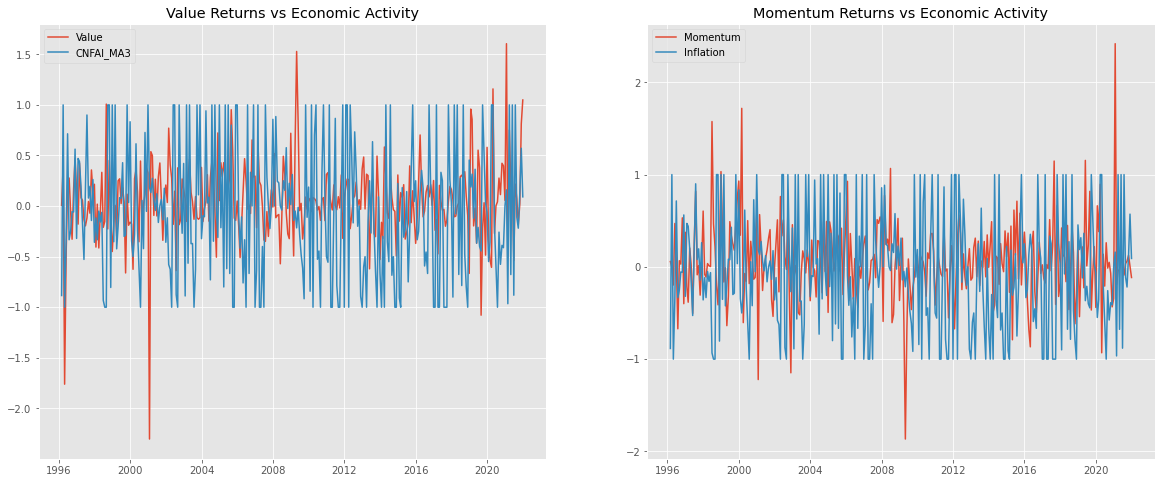

In [25]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(factor_ret_df.loc[start_date:end_date, 'Value'] * 12, label = 'Value')
ax1.plot(timing_var_df.loc[start_date:end_date, 'CNFAI_MA3_pct'], label = 'CNFAI_MA3')
ax1.set_title('Value Returns vs Economic Activity')
ax1.legend()

ax2.plot(factor_ret_df.loc[start_date:end_date, 'Momentum'] * 12, label = 'Momentum')
# ax21 = ax2.twinx()
ax2.plot(timing_var_df.loc[start_date:end_date, 'CNFAI_MA3_pct'],  label = 'Inflation')
ax2.set_title('Momentum Returns vs Economic Activity')
ax2.legend()

plt.show

<AxesSubplot:>

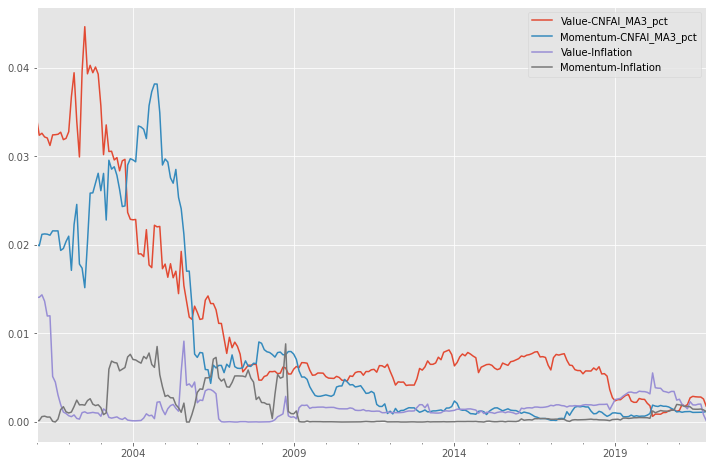

In [28]:
# r^2 of univariate regression
timevar_list = ['CNFAI_MA3_pct', 'Inflation']
factor_list = ['Value', 'Momentum']
expanding_window = pd.date_range(test_start_date0, test_end_date0, freq = 'M')

r2_table = pd.DataFrame(index = expanding_window)

for last_date in expanding_window: 
    for timevar in timevar_list: 
        for factor in factor_list: 
            r2, beta0, beta1 = run_ols(timevar, factor , train_start_date0, last_date)
            r2_table.loc[last_date, factor + '-' + timevar] = r2
    
r2_table.plot(figsize = (12,8))

Wow this is interesting... I wonder if its the same for the AQR/Fama-French factors... Also, does rolling-window perform better? 

<a id = 'results'> </a>
<h3> Results  

In [59]:
# compute gamma
mom_inflation = calc_gamma('Momentum', factor_ret_df, 'Inflation', timing_var_df)
mom_GDP = calc_gamma('Momentum', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)
val_inflation = calc_gamma('Value', factor_ret_df, 'Inflation', timing_var_df)
val_GDP = calc_gamma('Value', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum'] # static 60-40 
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum'] # static 40-60

factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

# target portfolio weights
factor_weights_test = {}
factor_weights_test['ValMom-50-50'] = 0.5 * (factor_weights['Value'] + factor_weights['Momentum']) 
factor_weights_test['ValMom-60-40'] = 0.6 * factor_weights['Value'] + 0.4 * factor_weights['Momentum']
factor_weights_test['ValMom-40-60'] = 0.4 * factor_weights['Value'] + 0.6 * factor_weights['Momentum'] 

gamma1 = (mom_inflation['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma1'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma1, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma1, axis = 0)

gamma2 = (mom_GDP['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma2'] = factor_weights['Value'].loc[expanding_window].mul(1 - gamma2, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(gamma2, axis = 0)

gamma3 = (val_inflation['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma3'] = factor_weights['Value'].loc[expanding_window].mul(gamma3, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1 - gamma3, axis = 0)

gamma4 = (val_GDP['Gamma']).shift(-1, freq = 'infer')
factor_weights_test['ValMom-gamma4'] = factor_weights['Value'].loc[expanding_window].mul(gamma4, axis = 0) + factor_weights['Momentum'].loc[expanding_window].mul(1- gamma4, axis = 0)

factor_returns_test

C:\Users\tyyew\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
2001-02-28,0.044791,0.047163,0.045977,0.045740,0.046214,0.045977,0.045977,0.045977,0.045977
2001-03-31,0.041525,0.017735,0.029630,0.032009,0.027251,0.028151,0.029248,0.020550,0.028976
2001-04-30,-0.007707,-0.021373,-0.014540,-0.013173,-0.015906,-0.014878,-0.013969,-0.011416,-0.013380
2001-05-31,0.022085,0.000389,0.011237,0.013407,0.009067,0.011562,0.009605,0.009464,0.009173
2001-06-30,-0.008163,0.007823,-0.000170,-0.001768,0.001429,-0.000929,0.000288,0.004844,0.001055
...,...,...,...,...,...,...,...,...,...
2021-08-31,0.005977,0.002952,0.004464,0.004767,0.004162,0.004171,0.005171,0.003833,0.003080
2021-09-30,-0.015206,0.005110,-0.005048,-0.007080,-0.003017,-0.004642,-0.015206,0.003225,-0.000892
2021-10-31,0.001585,0.010396,0.005991,0.005109,0.006872,0.005885,0.006208,0.008272,0.007361
2021-11-30,0.067740,0.000587,0.034163,0.040879,0.027448,0.039088,0.038889,0.067740,0.067510


In [34]:
# compute performance measures
summary_table(factor_weights, factor_returns_test, test_start_date, test_end_date)

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.086101,0.045199,0.065650,0.069740,0.061559,0.062464,0.079516,0.083475,0.059337
Volatility,0.350816,0.408671,0.229582,0.228051,0.246567,0.231792,0.259661,0.290972,0.301396
SharpeRatio,0.245429,0.110599,0.285952,0.305808,0.249666,0.269484,0.306230,0.286884,0.196874


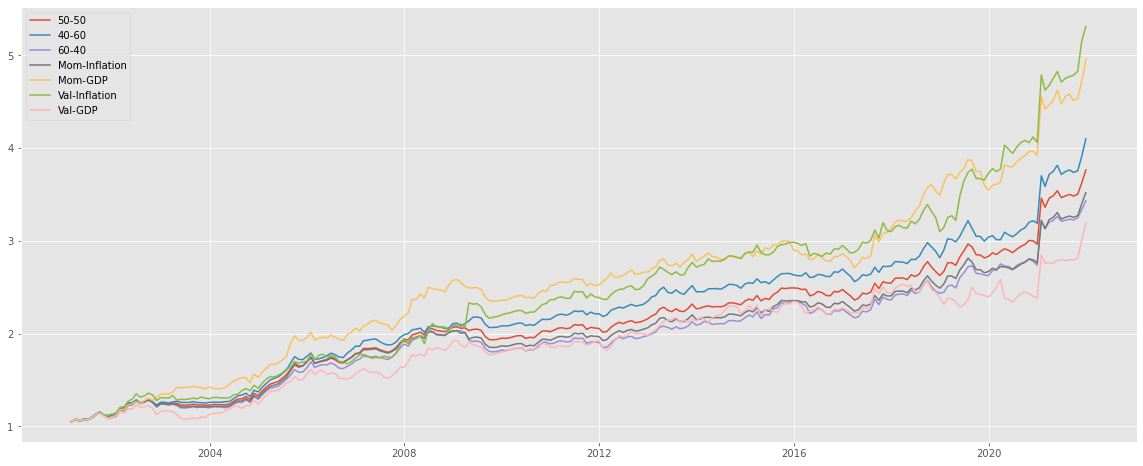

In [35]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-60-40'], label = '40-60')
plt.plot(factor_cumret['ValMom-40-60'], label = '60-40')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h4> <font color = 'darkblue'> Expanding Window </font> </h4>

In [37]:
# compute gamma
mom_inflation_ew = calc_gamma_ew('Momentum', factor_ret_df, 'Inflation', timing_var_df)
mom_GDP_ew = calc_gamma_ew('Momentum', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)
val_inflation_ew = calc_gamma_ew('Value', factor_ret_df, 'Inflation', timing_var_df)
val_GDP_ew = calc_gamma_ew('Value', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)

# target portfolio returns
factor_returns_test = factor_ret_df.loc[test_start_date:test_end_date].copy()

factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum']) # naive benchmark
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum'] # static 60-40 
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum'] # static 40-60

factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP_ew['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP_ew['Gamma'])

factor_returns_test

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
2001-02-28,0.044791,0.047163,0.045977,0.045740,0.046214,0.045977,0.045977,0.045977,0.045977
2001-03-31,0.041525,0.017735,0.029630,0.032009,0.027251,0.030132,0.029194,0.022959,0.028004
2001-04-30,-0.007707,-0.021373,-0.014540,-0.013173,-0.015906,-0.014047,-0.013837,-0.008688,-0.012927
2001-05-31,0.022085,0.000389,0.011237,0.013407,0.009067,0.010904,0.009775,0.008389,0.008324
2001-06-30,-0.008163,0.007823,-0.000170,-0.001768,0.001429,0.000640,0.000263,0.006834,0.001714
...,...,...,...,...,...,...,...,...,...
2021-08-31,0.005977,0.002952,0.004464,0.004767,0.004162,0.004653,0.004854,0.005536,0.003946
2021-09-30,-0.015206,0.005110,-0.005048,-0.007080,-0.003017,-0.005523,-0.001824,-0.005832,-0.011318
2021-10-31,0.001585,0.010396,0.005991,0.005109,0.006872,0.006145,0.006083,0.006220,0.005868
2021-11-30,0.067740,0.000587,0.034163,0.040879,0.027448,0.028516,0.036162,0.030027,0.031991


In [38]:
# compute performance measures
summary_table(factor_weights, factor_returns_test, test_start_date, test_end_date)

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.086101,0.045199,0.065650,0.069740,0.061559,0.070999,0.077732,0.073823,0.067802
Volatility,0.350816,0.408671,0.229582,0.228051,0.246567,0.232697,0.251180,0.260652,0.250307
SharpeRatio,0.245429,0.110599,0.285952,0.305808,0.249666,0.305112,0.309467,0.283225,0.270876


Expanding window gives slightly better results, which is not surprising since we are improving our factor return estimates.

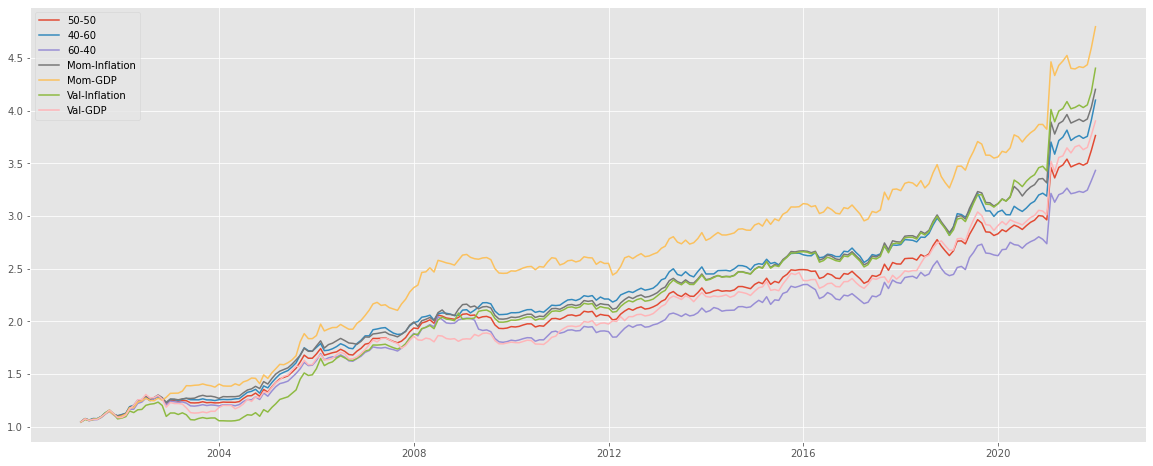

In [40]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-60-40'], label = '40-60')
plt.plot(factor_cumret['ValMom-40-60'], label = '60-40')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h4> <font color = 'darkblue'> Rolling Window </font> </h4>

In [ ]:
# compute gamma
mom_inflation_ew = calc_gamma_ew('Momentum', factor_ret_df, 'Inflation', timing_var_df)
mom_GDP_ew = calc_gamma_ew('Momentum', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)
val_inflation_ew = calc_gamma_ew('Value', factor_ret_df, 'Inflation', timing_var_df)
val_GDP_ew = calc_gamma_ew('Value', factor_ret_df, 'CNFAI_MA3_pct', timing_var_df)

# target portfolio returns
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP_ew['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation_ew['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP_ew['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP_ew['Gamma'])

factor_returns_test

<h2> 4. Appendix

<h3> A. Timing Variables on AQR Factors </h3> 

We tested our timing variables on the value and momentum factor returns given in [Ilmanen (2019)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3400998) to see if the sensitivies vary depending on factor construction. 

In [ ]:
path3 = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\Timing Variables.xlsx"
timing_variables = pd.read_excel(path3,sheet_name = "Timing Variables", index_col = 0).fillna(0)
factor_returns1 = pd.read_excel(path3,sheet_name = "Factor Returns", index_col = 0, usecols = ['Date', 'Value', "Momentum"])

In [ ]:
# whole period
start_date0 = pd.Timestamp('1989-12-31')
start_date = start_date0 + DateOffset(months=1)
end_date0 = pd.Timestamp('2022-01-31')
end_date = end_date0 + DateOffset(months=1)
# training period
train_start_date0 = pd.Timestamp('1989-12-31')
train_start_date = train_start_date0 + DateOffset(months=1)
train_end_date0 = pd.Timestamp('1999-12-31')
train_end_date = train_end_date0 + DateOffset(months=1)
# testing period
test_start_date0 = pd.Timestamp('2000-01-31')
test_start_date = test_start_date0 + DateOffset(months=1)
test_end_date0 = pd.Timestamp('2022-01-31')
test_end_date = test_end_date0 + DateOffset(months=1)

In [ ]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(factor_returns.loc[start_date:end_date, 'Value'] * 12, label = 'Value')
ax1.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'], label = 'CNFAI_MA3')
ax1.set_title('Value Returns vs Economic Activity')
ax1.legend()

ax2.plot(factor_returns.loc[start_date:end_date, 'Momentum'] * 12, label = 'Momentum')
# ax21 = ax2.twinx()
ax2.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'],  label = 'Inflation')
ax2.set_title('Momentum Returns vs Economic Activity')
ax2.legend()

plt.show

In [ ]:
# compute gamma
mom_inflation = calc_gamma('Momentum', 'Inflation')
mom_GDP = calc_gamma('Momentum', 'CNFAI_MA3')
val_inflation = calc_gamma('Value', 'Inflation')
val_GDP = calc_gamma('Value', 'CNFAI_MA3')

In [ ]:
# populate target portfolio returns
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

In [ ]:
# compute performance measures
summary_table(factor_returns_test)

In [ ]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-60-40'], label = '40-60')
plt.plot(factor_cumret['ValMom-40-60'], label = '60-40')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h3> B. Gamma </h3>

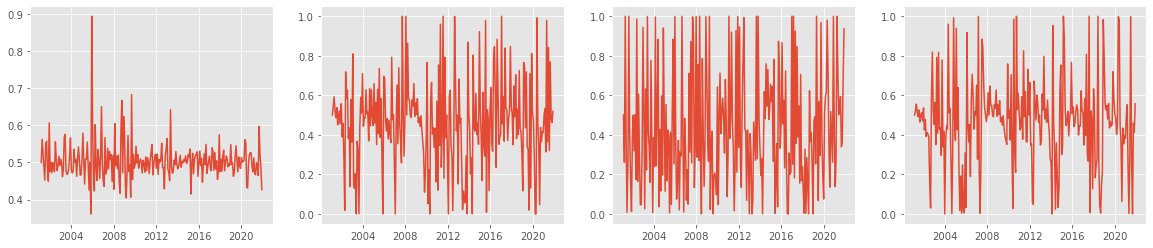

In [569]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,4))

ax1.plot(mom_inflation['Gamma'])
ax2.plot(mom_GDP['Gamma'])
ax3.plot(val_inflation['Gamma'])
ax4.plot(val_GDP['Gamma'])

A natural question here is the correlation between gamma and outperformance against the 50-50 portfolio.

In [570]:
tmp = pd.DataFrame(columns = ['Gamma 1 Return', 'Gamma 1'])
tmp['Gamma 1 Return'] = factor_returns_test['ValMom-gamma1'] - factor_returns_test['ValMom-50-50'] 
tmp['Gamma 1'] = np.abs(mom_inflation['Gamma'].pct_change())
tmp.corr()

,Gamma 1 Return,Gamma 1
Gamma 1 Return,1.000000,0.067526
Gamma 1,0.067526,1.000000


<h3> C. Bounded Gamma </h3>

In [382]:
# 40-60 bound
mom_inflation = calc_gamma('Momentum', 'Inflation', 0.6, 0.4)
mom_GDP = calc_gamma('Momentum', 'CNFAI_MA3', 0.6, 0.4)
val_inflation = calc_gamma('Value', 'Inflation', 0.6, 0.4)
val_GDP = calc_gamma('Value', 'CNFAI_MA3', 0.6, 0.4)

In [386]:
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

In [387]:
# compute performance measures
ret_annualized = np.mean(factor_returns_test.loc[start_date:end_date]) * 12
vol_annualized = np.std(factor_returns_test.loc[start_date:end_date]) * 12
sharpe = np.mean(factor_returns_test.loc[start_date:end_date])/ np.std(factor_returns_test.loc[start_date:end_date])
# turnover = 
# drawdown = 
# transaction_cost = 
# information_ratio = 
summary = pd.DataFrame(columns = ['Return', 'Volatility', 'SharpeRatio'])
summary['Return'] = ret_annualized
summary['Volatility'] = vol_annualized
summary['SharpeRatio'] = sharpe
summary.T

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.038242,0.027217,0.032729,0.033832,0.031627,0.038911,0.036104,0.031151,0.035709
Volatility,0.511266,0.627434,0.213937,0.209312,0.265080,0.215058,0.210584,0.239608,0.212170
SharpeRatio,0.074799,0.043378,0.152986,0.161634,0.119311,0.180931,0.171447,0.130009,0.168303


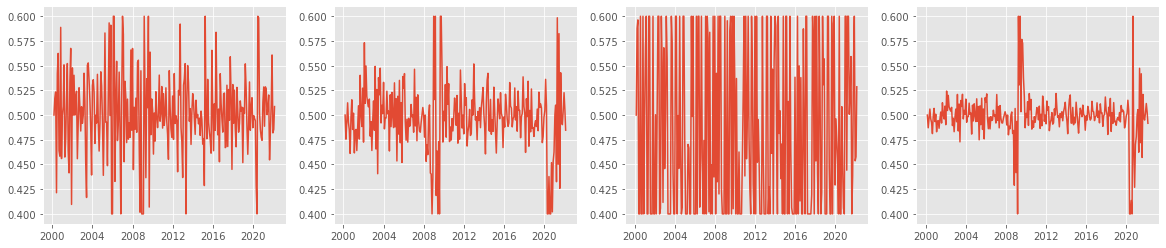

In [388]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,4))

ax1.plot(mom_inflation['Gamma'])
ax2.plot(mom_GDP['Gamma'])
ax3.plot(val_inflation['Gamma'])
ax4.plot(val_GDP['Gamma'])